# эксперименты для многокритериальной оптимизациии

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from jax import  numpy as jnp
from jax import grad, jacobian
import jax

import multiobjective_opt.function_handler as fh

### Online Grad Descent

Рассмотрим случайные квадратичные формы как оптимизируемые функции

Они зависят от тех же параметров, так что будет происходить конкурентная оптимизация

In [3]:
from multiobjective_opt.functions import QuadForm, LinearFunc
from multiobjective_opt.w_generators import StochasticWGenerator
from multiobjective_opt.online_optimizers import OnlineGradientDescent


In [4]:
d = 10
m = 3
T = 400

# определяем функции
functions = [QuadForm(d) for _ in range(m)]
functions = [fh.JaxFunc(f) for f in functions]
vectored_func = fh.stack_functions(functions)

def wXvec(w, x):
    return w @ vectored_func(x)

wx = fh.JaxFunc(wXvec, grad_kwargs={"argnums": 1})

# определяем генератор
w_generator = StochasticWGenerator(m, T)
    
# определяем оптимизатор
optimizer = OnlineGradientDescent(wx, 
                                  w_generator=w_generator, 
                                  lr_scaler = 0.07)

x = np.zeros((d))
res = optimizer.run(x)

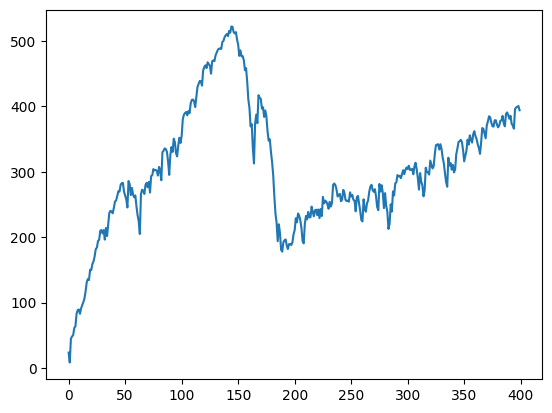

In [5]:
w_exp = np.ones(m, float)/m

def f(x):
    res = w_exp @ vectored_func(x)
    return res

val = minimize(f, np.random.rand(d), jac= grad(f))
minimizer = val.x

regret = [loss - (t + 1) * val.fun for t, loss in enumerate(res.losses)]

plt.plot(regret)

Рассмотрим линейные функции

оптимизируем на множестве $[0,1]^d$

In [6]:
d = 10
m = 3
T = 800

functions = [LinearFunc(d) for _ in range(m)]
vectored_func = fh.stack_functions(functions)

def wXvec(w, x):
    return w @ vectored_func(x)

wx = fh.JaxFunc(wXvec, grad_kwargs={"argnums": 1})

# определяем генератор
w_generator = StochasticWGenerator(m, T)
    
# определяем prox function
def projection(x):
    return np.clip(x, 0., 1.)
# определяем оптимизатор
optimizer = OnlineGradientDescent(wx, 
                                  w_generator=w_generator, 
                                  lr_scaler = 0.07, 
                                  projection_function= projection)

x = np.zeros((d))
res = optimizer.run(x)
    

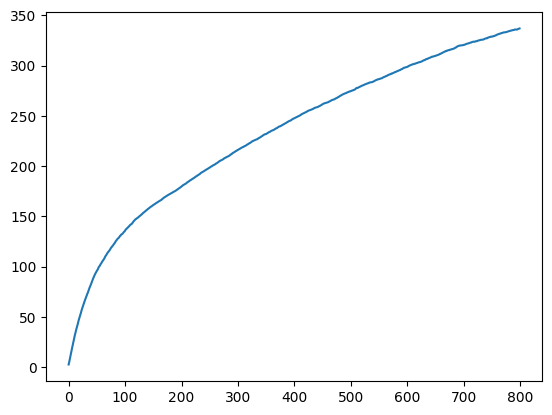

In [7]:
from scipy.optimize import Bounds, minimize

w_exp = np.ones(m, float)/m

def f(x):
    res = w_exp @ vectored_func(x)
    return res

val = minimize(f,
               x0=np.ones(d) * 0.5,
               bounds= Bounds(np.zeros(d), np.ones(d)),
               jac= grad(f))

minimizer = val.x
regret = [loss - (t + 1) * val.fun for t, loss in enumerate(res.losses)]

plt.plot(regret)

### RFTL

In [7]:
from multiobjective_opt.online_optimizers import RFTL
from scipy.optimize import Bounds, minimize
from multiobjective_opt.functions import ModularFunc

d = 2
m = 10
T = 5_00

functions = [ModularFunc(d) for _ in range(m)]
vectored_func = fh.stack_functions(functions)

def wXvec(w, x):
    return w @ vectored_func(x)

wx = fh.JaxFunc(wXvec, grad_kwargs={"argnums": 1})

bounds = Bounds(-np.ones(d) * 2, np.ones(d) * 2)

from scipy.optimize import Bounds, minimize

w_exp = np.ones(m, float)/m

def f(x):
    res = w_exp @ vectored_func(x)
    return res

val = minimize(f,
               x0=np.ones(d) * 0.5,
               bounds=  bounds,
               jac= grad(f))

minimizer = val.x


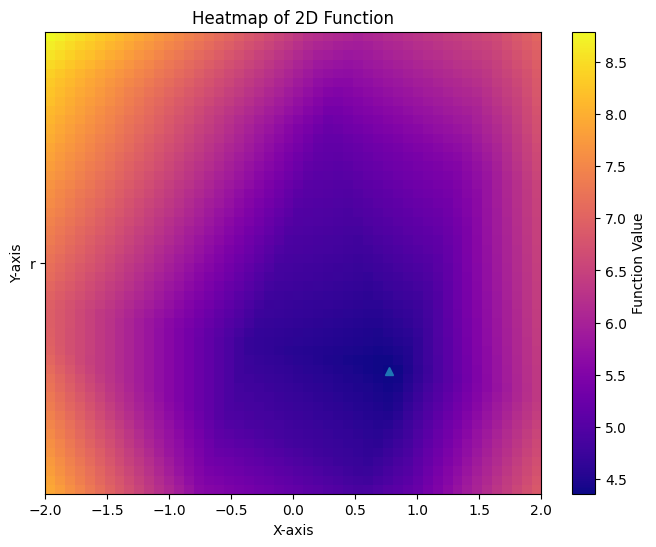

In [8]:
# рисует heatmap
import numpy as np
import matplotlib.pyplot as plt

def generate_heatmap(func, x_range, y_range, resolution=100, cmap='viridis'):
    """
    Рисует heatmap для заданной двумерной функции.

    :param func: Двумерная функция f(x, y)
    :param x_range: Кортеж (x_min, x_max) для диапазона x
    :param y_range: Кортеж (y_min, y_max) для диапазона y
    :param resolution: Разрешение сетки (количество точек по каждой оси)
    :param cmap: Цветовая карта для heatmap
    """
    # Создаем сетку
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((resolution,resolution), dtype= float)
    # Вычисляем значения функции
    min_val = float("inf")
    min_pos = None
    for i in range(resolution):
        for j in range(resolution):
            Z[i][j] = func(X[i][j], Y[i][j])
            if min_val > Z[i][j]:
                min_val = Z[i][j]
                min_pos = (i,j)

    # Создаем heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=(x_range[0], x_range[1], y_range[0], y_range[1]), 
               origin='lower', cmap=cmap, aspect='auto')
    plt.colorbar(label='Function Value')

    plt.title('Heatmap of 2D Function')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    # рисуем минимум
    i, j = min_pos
    x, y = X[i][j], Y[i][j]
    plt.plot(x, y, "^", 'r')
    plt.show()

# Пример использования
def example_func(x, y):
    return f(np.array([x, y]))

generate_heatmap(example_func, x_range=(-2, 2), y_range=(-2, 2), resolution=50, cmap='plasma')

In [9]:
# определяем генератор

w_generator = StochasticWGenerator(m, T, seed = 1)
    

# определяем prox function
def projection(x):
    return np.clip(x, 0., 1.)
# определяем оптимизатор
optimizer = RFTL(wx, 
                w_generator=w_generator, 
                eta = 0.1, 
                projection_function= projection)

x = np.zeros((d))
res_rftl = optimizer.run(x, bounds= bounds)
    

0it [00:00, ?it/s]

500it [00:11, 43.66it/s]


In [ ]:
from multiobjective_opt.online_optimizers import RFTL_structured
# определяем генератор

w_generator = StochasticWGenerator(m, T, seed = 1)
    
# определяем prox function
def projection(x):
    return np.clip(x, 0., 1.)
# определяем оптимизатор
optimizer = RFTL_structured(wx, 
                w_generator=w_generator, 
                eta = 10., 
                projection_function= projection)

x = np.zeros((d))
res_rftl_struct = optimizer.run(x,vectored_func, bounds=  bounds)
    

0it [00:00, ?it/s]

43it [00:22,  2.00it/s]

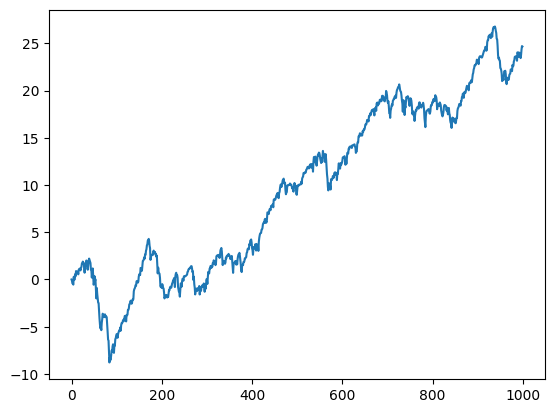

In [72]:
regret_rftl = [loss - (t + 1) * val.fun for t, loss in enumerate(res_rftl.losses)]
regret_rftl_struct = [loss - (t + 1) * val.fun for t, loss in enumerate(res_rftl_struct.losses)]
relative = [loss_rf - loss_reg for loss_rf, loss_reg in zip(res_rftl.losses, res_rftl_struct.losses)]
plt.plot(relative)


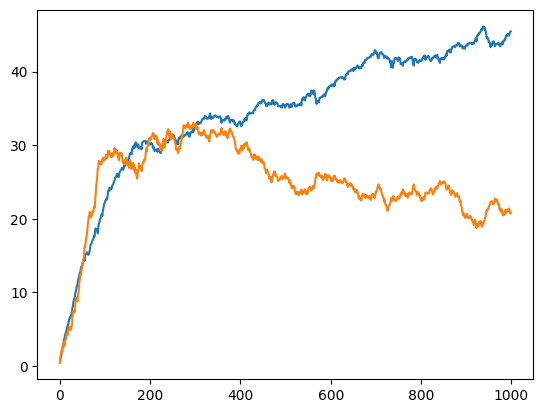

In [78]:
plt.plot(regret_rftl)
plt.plot(regret_rftl_struct)

In [79]:
minimizer

array([ 2.        , -1.01112754])

In [80]:
res_rftl.x

array([ 2.        , -0.85843736])

In [81]:
res_rftl_struct.x

array([ 2.        , -1.01137355])

In [82]:
f(minimizer), f(res_rftl.x), f(res_rftl_struct.x)

(Array(4.7119074, dtype=float32),
 Array(4.7147446, dtype=float32),
 Array(4.7119026, dtype=float32))